***Méthodes numériques: Module 2***
***********************************
Space and Time: Modélisation de l'écoulement du trafic.
==
## Introduction #

Dans ce module nous allons résoudre une équation non-linéaire à deux variables en discrétisant à la fois dans le temps (en utilisant la forward-difference) et dans l'espace (en utilisant la backward-difference). Nous utiliserons également les nouveaux outils introduit dans ce module: sympy et lambdify, qui nous permettrons d'écrire des formules mathématiques dans nos codes et d'utiliser des fonctions de manière plus confortable. 

Comme dans le module 1, nous importons la librairie numpy et matplotlib pour pouvoir dessiner des graphiques, mais également sympy et lambdify.

In [1]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

## Principe #

L'équation que l'on se propose de résoudre est la suivante: $$\frac{\partial{\rho}}{\partial{t}}+\frac{\partial{F}}{\partial{x}}=0$$ 

Cette équation modélise le flux du trafic de voitures sur l'autoroute. Il s'agit en fait de l'équation non-linéaire de convection appliquée à la densité de voiture, $\rho$. La fonction F représente le flux des voitures donné par $F=V \rho$ où V est la vitesse moyenne des voitures.

On modélise le fait que la vitesse varie en fonction de la densité de voiture en exprimant que la vitesse est maximale quand la densité de voiture est nulle et qu'elle est nulle quand la densité de voiture atteind une densité critique que l'on appelle $\rho_{max}$, ce qui se traduit par la formule suivante: 

$$V = V_{max}(1-\frac{\rho}{\rho_{max}})$$

Nous voulons discrétiser notre équation en utilisant l'approximation de la dérivée vers l'avant pour le temps et vers l'arrière pour l'espace, c'est-à-dire:

$$\frac{\partial{\rho}}{\partial{t}} \cong \frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t}$$ et 
$$\frac{\partial{F}}{\partial{x}} \cong \frac{F_{i}^{n} - F_{i-1}^{n}}{\Delta x}$$

### Remarques:
- Les exposants représentent les indices de temps (n) et les indices en dessous sont les indices pour l'espace (i).
- $F_{i}^{n}=F(\rho_{i}^{n})$. Nous avons d'abord pensé à développer l'équation à discrétiser en exprimant tout en termes de $\rho$, mais cela augmente l'erreur que l'on fait en discrétisant et il est préférable de discrétiser F et de calculer directement sa valeur à chaque instant et point de l'espace.

L'équation devient: $$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t}=\frac{F_{i}^{n} - F_{i-1}^{n}}{\Delta x}$$ 
$$\Leftrightarrow$$

$$\rho_{i}^{n+1}= \rho_{i}^{n}+\frac{\Delta t}{\Delta  x}(F_{i}^{n} - F_{i-1}^{n})$$
où à chaque étape, la seule inconnue est $\rho_{i}^{n+1}$.

## Code

Nous commencons par créer la fonction F($\rho$) que nous pourrons ensuite réutiliser telle quelle dans le code.

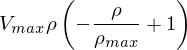

In [2]:
rho=sympy.symbols('rho')
V_max=sympy.symbols('V_max')
rho_max=sympy.symbols('rho_max')
F=rho*V_max*(1-rho/rho_max)
flamb=lambdify((rho,V_max,rho_max),F)
F

Nous allons résoudre l'équation pour différents paramètres de départ. Certains paramètres, comme la longueur sur laquelle nous étudions cette équation, seront les mêmes pour tous les cas et nous les fixons donc à l'avance. Ce sont les paramètres invariants.

### Paramètres invariants du problème.

In [3]:
L=11 #km
rhomax=250.#voitures/km
nx=51
dx=L/(nx-1)
dt=.001#heures

### Fonction: Calcul de $\rho$ et $v$.
Afin de pouvoir facilement déterminer les solutions de l'équation en partant de conditions initiales différentes, le code qui va discrétiser l'équation est mis sous forme de fonction. Elle nous donnera la densité, le flot F et la vitesse du trafic sur la portion de route considérée à partir des variables suivantes :

- $\rho$(x,0) la condition initiale (=initial)
- numberstep: le nombre de pas de temps effectués. En faisant varier ce nombre, nous pourrons choisir le temps auquel on souhaite obtenir $\rho$, $v$, et $F$.
- $\rho$(0,t) la condition aux limites (=bound)
- $V_{max}$ la vitesse maximale des voitures atteinte lorsque la densité du trafic est (quasi) nulle. 

On implémente cette équation pour calculer la densité à une position n : $$\rho_{i}^{n+1}= \rho_{i}^{n}+\frac{\Delta t}{\Delta  x}(F_{i}^{n} - F_{i-1}^{n})$$
et celle-ci pour calculer la vitesse : $V = V_{max}(1-\frac{\rho}{\rho_{max}})$

In [4]:
def rho(initial,numberstep,bound,vmax):
    rho00=initial.copy() #Cette copie de la densité initiale nous assure de garder "initial" inchangée par le processus.
    for n in range(1,numberstep): 
        rhocopy = rho00.copy()
        rho00[1:] = rhocopy[1:]-dt/dx*(flamb(rhocopy[1:],vmax,rhomax)-flamb(rhocopy[0:-1],vmax,rhomax))
        rho00[0] = bound
    u=numpy.array([rho00,vmax*(1-rho00/rhomax)/3.6,flamb(rho00,vmax,rhomax)])#on divise la vitesse par 3.6 car la vitesse doit être finalement exprimée en m/s
    return u

- $rho$ donnera donc un vecteur $\boldsymbol{u} = (\rho,v,F)$ avec $\rho,v, F$ en positions respectives 0,1 et 2.

Remarque: $\rho$ est exprimé en voitures/km, v en m/s et F en voitures/heure

## Simulation result: Part A.

- Soit la densité initiale suivante :

In [5]:
x = numpy.linspace(0,L,nx)#x est défini une seule fois pour les deux simulations car il ne change pas
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

- Voyons l'allure de cette densité répartie sur la portion de route :

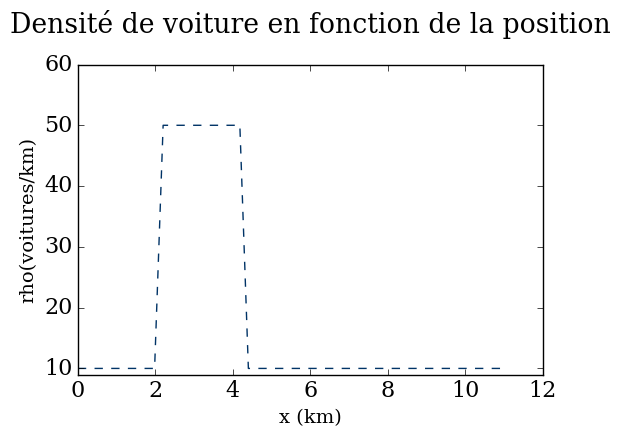

In [6]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho(voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voiture en fonction de la position', y=1.08)

- On peut modifier le second argument ($nt$) de la fonction rho pour voir l'allure de la densité, du flot ou de la vitesse sur le segment de longueur 11km au temps $t=nt*0.001 h=nt*0.06 minutes$.

On crée une fonction pratique qui trouve nt à partir du temps donné en minutes :

In [7]:
def time(t):
    nt=int(t/0.06)+1
    return nt

(Nous utiliserons cette fonction plusieurs fois par la suite)

###### À titre d'exemple, voyons l'allure de la densité, de la vitesse et du flot du trafic sur la portion de route après 2,5 minutes :


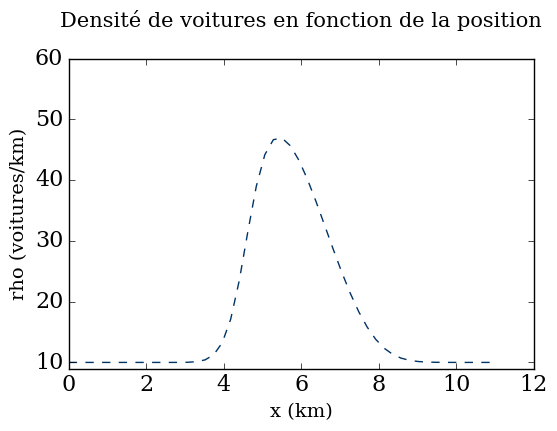

In [8]:
pyplot.plot(x,rho(rho0,time(2.5),10,80.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08, fontsize=15)

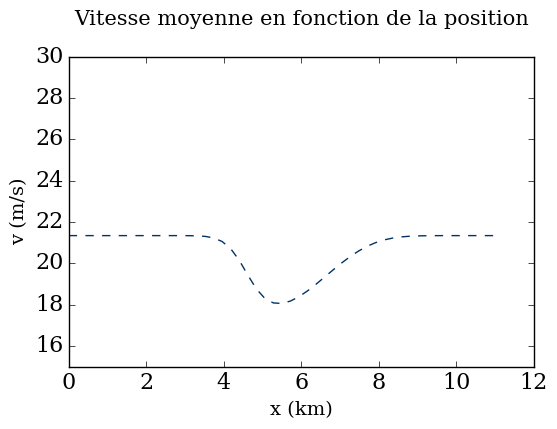

In [9]:
pyplot.plot(x,rho(rho0,time(2.5),10,80.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(15.,30.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('v (m/s)', fontsize=14) #y label
pyplot.title('Vitesse moyenne en fonction de la position', y=1.08, fontsize=15)

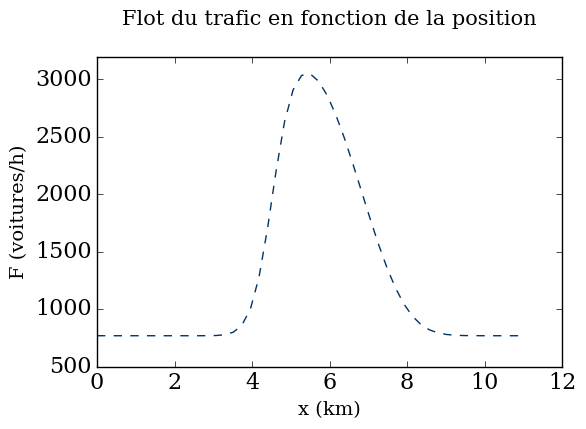

In [10]:
pyplot.plot(x,rho(rho0,time(2.5),10,80.0)[2], color='#003366', ls='--', lw=1)
pyplot.ylim(500.,3200.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('F (voitures/h)', fontsize=14) #y label,
pyplot.title('Flot du trafic en fonction de la position', y=1.08, fontsize=15)

## Simulation result: Part B.

- Soit une autre densité initiale :

In [11]:
rho1 = numpy.ones(nx)*20 
rho1[10:20] = 50

- Voyons l'allure de cette densité répartie sur la portion de route :

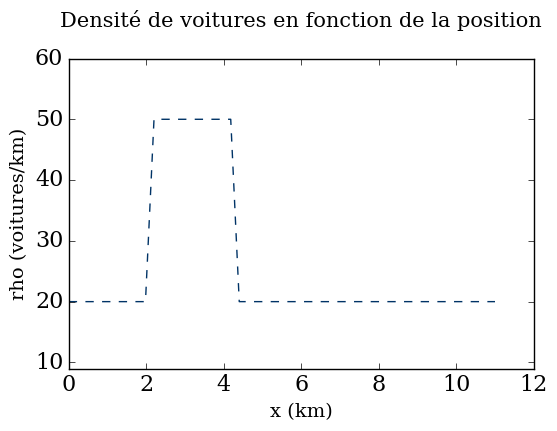

In [12]:
pyplot.plot(x, rho1, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08, fontsize=15)

###### À nouveau, voyons l'allure de la densité, de la vitesse et du flot de trafic sur la portion de route après 2,5 minutes :

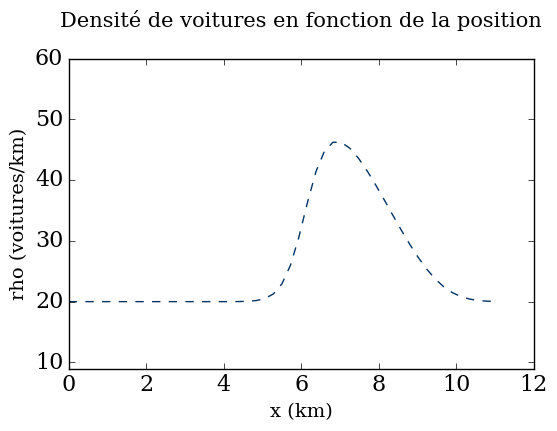

In [13]:
pyplot.plot(x,rho(rho1,time(2.5),20,136.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08, fontsize=15)

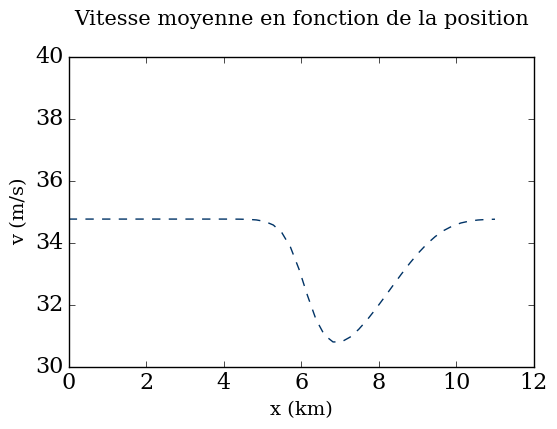

In [14]:
pyplot.plot(x,rho(rho1,time(2.5),20,136.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(30,40);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('v (m/s)', fontsize=14) #y label
pyplot.title('Vitesse moyenne en fonction de la position', y=1.08, fontsize=15)

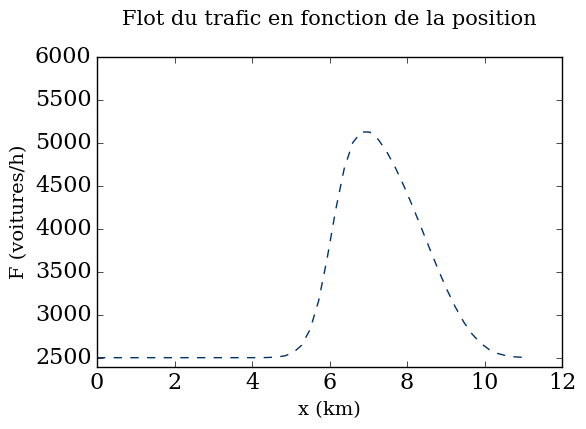

In [15]:
pyplot.plot(x,rho(rho1,time(2.5),20,136.0)[2], color='#003366', ls='--', lw=1)
pyplot.ylim(2400.,6000.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('F (voitures/h)', fontsize=14) #y label
pyplot.title('Flot du trafic en fonction de la position', y=1.08, fontsize=15)

### Questions

Dans cette section, nous répondons aux questions posées dans l'énoncé pour chacune des deux simulations.

- Nous créons tout d'abord deux fonctions, vmin et vmean, qui donnerons respectivement la vitesse minimale et la vitesse moyenne pour une densité initiale, une condition au bord $\rho(0,t)=bound$ et un $V_{max}$ fixé, à un temps t donné.

In [16]:
def vmin(initial,t,bound,vmax):
    vmi=rho(initial,time(t),bound,vmax)[1]

    return(numpy.min(vmi)) 

In [17]:
def vmean(initial,t,bound,vmax):
    u=rho(initial,time(t),bound,vmax)[1]

    return numpy.mean(u)

##### PART A

$\underline{Note}$ : Toutes les vitesses seront données en m/s et arrondies à la deuxième décimale.

Initialement, la vitesse minimale est : 

In [18]:
round(vmin(rho0,0,10,80.0),2)

À t = 3 minutes, la vitesse moyenne est :

In [19]:
round(vmean(rho0,3,10,80.0),2)

À t = 6 minutes, la vitesse minimale est :

In [20]:
round(vmin(rho0,6,10,80.0),2)

##### PART B

$\underline{Note}$ : Toutes les vitesses seront données en m/s et arrondies à la deuxième décimale.

Initialement, la vitesse minimale est : 

In [21]:
round(vmin(rho1,0,20,136.0),2)

À t = 3 minutes, la vitesse moyenne est : 

In [22]:
round(vmean(rho1,3,20,136.0),2)

À t = 3 minutes, la vitesse minimale est :

In [23]:
round(vmin(rho1,3,20,136.0),2)

## Bonus: vidéo

Dans cette section, nous réalisons l'animation de la variation de la courbe de densité pour la partie A au cours du temps.

In [24]:
from matplotlib import animation
from IPython.display import HTML

Donnons un nombre nt de pas de temps effectués avant la fin de l'animation qui soit suffisamment grand et redonnons $V_{max}$ ainsi que la densité initiale :

In [25]:
nt=150
vmax=80.
u = numpy.ones(nx)*10
u[10:20] = 50
un=numpy.ones(nx)

Nous définissons le cadre dans lequel l'animation aura lieu.

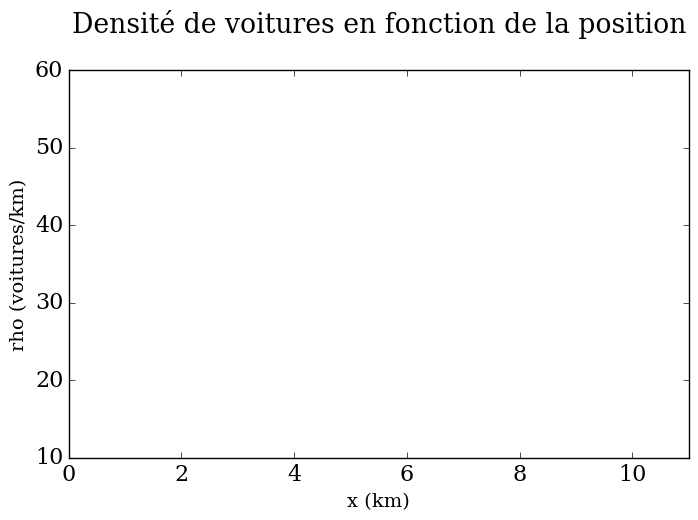

In [26]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,11), ylim=(10,60))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08)

On reconstruit la densité comme nous l'avons fait dans la fonction rho, avec la condition au bord : $\rho (0,t)=10$ :

In [27]:
def density(i):
    line.set_data(x,u)
    
    un = u.copy() 
    u[1:] = un[1:]-dt/dx*(flamb(un[1:],vmax,rhomax)-flamb(un[0:-1],vmax,rhomax))
    u[0] = 10

In [28]:
anim = animation.FuncAnimation(fig, density,frames=nt, interval=100)

Voyons maintenant comment la densité évolue au cours du temps sur la portion de route considérée.

In [29]:
HTML(anim.to_html5_video())

## Interprétation physique des résultats obtenus

